In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/Users/itobuz/data.csv")

In [4]:
# Define time of day buckets
def time_of_day(hour):
    if hour < 12:
        return 0
    elif hour < 18:
        return 1
    elif hour < 22:
        return 2
    else:
        return 3
df['time_of_day'] = df['order_hour_of_day'].apply(time_of_day)
# Days Since Last Purchase
df['days_since_last_purchase'] = df.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(-1).fillna(0)
# Number of orders per user
df['user_order_count'] = df.groupby('user_id')['order_id'].transform('count')
# Sum of items ordered per order
df['total_items_ordered'] = df.groupby('order_id')['add_to_cart_order'].transform('sum')
# Total orders for each product
df['product_popularity'] = df.groupby('product_id')['order_id'].transform('count')
# Average order hour for each user
df['avg_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
# Order Frequency
df['order_frequency'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')
# Product Affinity by Department
df['department_affinity'] = df.groupby(['user_id', 'department_id'])['order_id'].transform('count') / df.groupby('user_id')['order_id'].transform('count')
# Time of Purchase Features
df['preferred_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
df['preferred_order_dow'] = df.groupby('user_id')['order_dow'].transform('mean')
# Average Reorder Rate
df['avg_reorder_rate'] = df.groupby(['user_id'])['reordered'].transform('mean')
# Product Reorder Frequency (across all users)
df['product_reorder_frequency'] = df.groupby('product_id')['reordered'].transform('sum')
# User's Reorder Rate for Product
df['user_product_reorder_rate'] = df.groupby(['user_id', 'product_id'])['reordered'].transform('mean')
# Order Count for Product by User
df['user_product_order_count'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')

In [5]:
df.drop(['department', 'aisle'], axis=1,inplace=True)

In [6]:
df.drop([ 'product_name'], axis=1,inplace=True)

In [7]:
df.drop(['department_id', 'aisle_id'], axis=1,inplace=True)

**Time of day buckets**
`# Time of day is categorized into 4 buckets: morning, afternoon, evening, and night.`  
`# This helps capture temporal patterns in user behavior. For example, some users may prefer ordering in the morning, while others may prefer evening or night orders.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Days Since Last Purchase**  
`# This calculates the days since a user last purchased a specific product.`  
`# It is a useful metric for understanding the user's purchase cycle and identifying products that may be due for reordering.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Number of orders per user**  
`# This feature tracks the total number of orders placed by a user.`  
`# Users who place more orders are more engaged and might have a higher likelihood of purchasing similar items in the future.`  
`# It helps in understanding user activity and engagement, which is key for personalization.`

---

**Sum of items ordered per order**  
`# This calculates the total number of items ordered in each order.`  
`# Orders with more items may indicate bulk buying or more diverse product preferences, which can be useful for recommending related items.`  
`# It helps to infer user preferences and buying habits, which improves recommendations.`

---

**Total orders for each product**  
`# This feature measures the popularity of each product by counting how many times it has been ordered across all users.`  
`# It is important for product recommender systems to give higher priority to popular items, as they tend to be more frequently purchased.`  
`# Popular products are often good candidates for recommendations.`

---

**Average order hour for each user**  
`# This calculates the average hour of the day when a user places orders.`  
`# It helps in identifying time-based purchasing patterns, allowing recommendations to align with the user's preferred order times.`  
`# Users who typically order at certain times may be more likely to buy products recommended during those times.`

---

**Order Frequency**  
`# This tracks how often a user purchases the same product.`  
`# High-frequency orders for a product indicate a strong preference or habit, which is important for identifying repeat purchases and cross-selling opportunities.`  
`# This feature helps in recommending products that a user frequently purchases.`

---

**Product Affinity by Department**  
`# This calculates the proportion of orders within a department for each user.`  
`# It helps to understand a user's affinity for different product departments (e.g., electronics, groceries).`  
`# It enables personalized recommendations based on user’s department preferences, improving the relevance of suggested products.`

---

**Time of Purchase Features: Preferred Hour and Day of Week**  
`# These features capture the user's preferred time of day and day of the week for placing orders.`  
`# Understanding when a user tends to make purchases can help recommend products at the right times, improving the likelihood of conversion.`  
`# It enhances temporal personalization in product recommendations.`

---

**Average Reorder Rate**  
`# This measures the average likelihood of a user reordering items.`  
`# A higher reorder rate indicates that the user is more likely to repurchase items they've ordered in the past.`  
`# This feature is important for recommending products the user may wish to reorder based on their previous behaviors.`

---

**Product Reorder Frequency (across all users)**  
`# This feature calculates how often a product is reordered across all users.`  
`# Products that are frequently reordered are strong candidates for recommendation, as they have a high likelihood of being bought again.`  
`# It helps to surface products that are not only popular but also have a high tendency for repeat purchases.`

---

**User's Reorder Rate for Product**  
`# This feature measures the likelihood that a specific user will reorder a specific product.`  
`# It helps to capture individual user-product interactions, which can be crucial for personalized product recommendations.`  
`# It enhances the ability to predict which products a user is most likely to reorder.`

---

**Order Count for Product by User**  
`# This calculates the number of times a user has ordered a specific product.`  
`# It is helpful for identifying products with high user-specific engagement, which can be used for creating personalized recommendations.`  
`# Products with higher order counts are more likely to be recommended to users who have shown strong interest in them.`

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# List the columns to scale
columns_to_scale = [
    'product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
        'preferred_order_dow', 'avg_reorder_rate',
        'user_product_reorder_rate']
# Fit and transform the scaler on the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [16]:
df.head()

,product_id,order_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_last_purchase,user_order_count,total_items_ordered,product_popularity,avg_order_hour,order_frequency,department_affinity,preferred_order_dow,avg_reorder_rate,user_product_reorder_rate
0,0.0,0.000323,0.041667,0.0,0.185531,0.010204,0.166667,0.478261,0.258065,0.000000,0.015314,0.014361,0.003917,0.516667,0.000000,0.066416,0.305556,0.353704,0.000000
1,0.0,0.001554,0.013889,1.0,0.951578,0.653061,0.166667,0.608696,0.064516,0.032258,0.119291,0.002551,0.003917,0.530201,0.357143,0.145184,0.428784,0.958583,0.982143
2,0.0,0.002203,0.020833,1.0,0.671642,0.071429,0.000000,0.608696,0.258065,0.258065,0.045943,0.002551,0.003917,0.660670,0.102041,0.108956,0.303640,0.772456,0.918367
3,0.0,0.002697,0.006944,0.0,0.386028,0.010204,0.333333,0.434783,1.000000,0.000000,0.006985,0.000850,0.003917,0.493253,0.000000,0.103208,0.540230,0.034848,0.000000
4,0.0,0.002710,0.201389,0.0,0.242493,0.000000,0.166667,0.652174,0.000000,0.258065,0.128694,0.052910,0.003917,0.699170,0.173469,0.311018,0.542531,0.863817,0.954082


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:

# Assuming df is your DataFrame and 'reordered' is the target variable
X = df.drop(columns=['reordered'])  # Features
y = df['reordered']  # Target variable

In [19]:
# Fit Logistic Regression model
log_reg = LogisticRegression(max_iter=5, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5, random_state=42)

In [ ]:
import matplotlib.pyplot as plt

# List of columns to plot histograms for
columns_to_plot = [
    'product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
    'order_number', 'order_dow', 'order_hour_of_day',
    'days_since_prior_order', 'days_since_last_purchase',
    'user_order_count', 'total_items_ordered', 'product_popularity',
    'avg_order_hour', 'order_frequency', 'department_affinity',
    'preferred_order_dow', 'avg_reorder_rate', 'user_product_reorder_rate'
]

# Number of rows and columns for subplots (adjust based on number of columns)
num_cols = 3  # For example, 3 columns per row
num_rows = len(columns_to_plot) // num_cols + (len(columns_to_plot) % num_cols > 0)

# Create a figure with subplots
plt.figure(figsize=(15, 12))

# Loop through columns and create a subplot for each
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)  # Create subplot at position i
    plt.hist(df[col], bins=20, edgecolor='black', alpha=0.7)  # Histogram
    plt.title(col)  # Set the title to the column name
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
from sklearn.model_selection import train_test_split
# Split X_test and y_test further into test and validation sets (50% each)
X_test_final, X_val, y_test_final, y_val = train_test_split(X_test, y_test, test_size=0.15, random_state=42)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Predict on the test set
y_pred = log_reg.predict(X_test_final)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test_final, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Alternatively, using the model's score method
accuracy_alternate = log_reg.score(X_test, y_test)
print(f"Model Accuracy (using score method): {accuracy_alternate:.4f}")

# Predict on the final test set
y_test_pred = log_reg.predict(X_test_final)

# Calculate the F1 score
f1 = f1_score(y_test_final, y_test_pred)
print(f"Model Accuracy (using f1-score method): {accuracy_alternate:.4f}")

Model Accuracy: 0.8462
Model Accuracy (using score method): 0.8462
Model Accuracy (using f1-score method): 0.8462


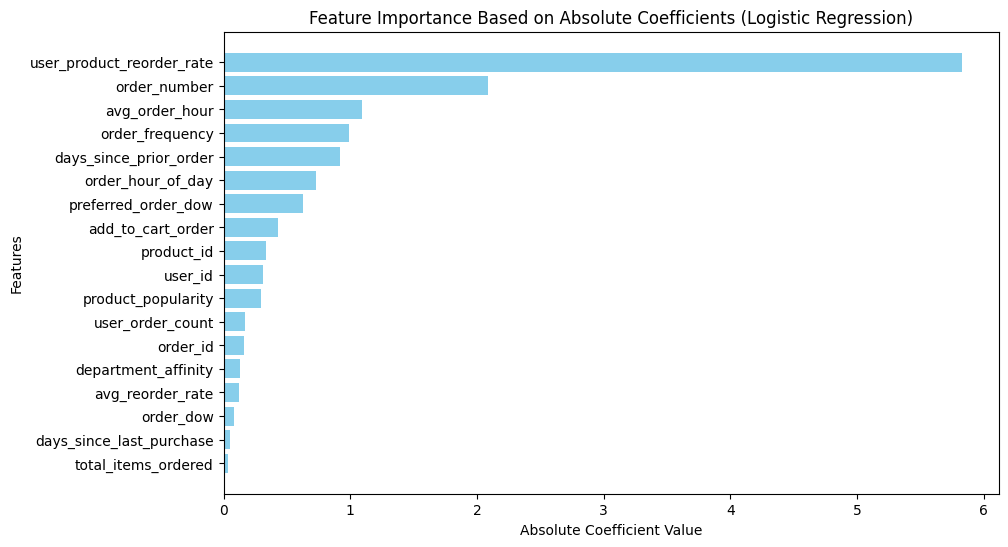

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already trained your Logistic Regression model
# and 'log_reg' is your fitted model

# Get the absolute value of coefficients
importance = np.abs(log_reg.coef_[0])

# Get feature names from X (features dataframe)
feature_names = X.columns

# Create a DataFrame to store feature names and their corresponding importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Absolute Coefficients (Logistic Regression)')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()


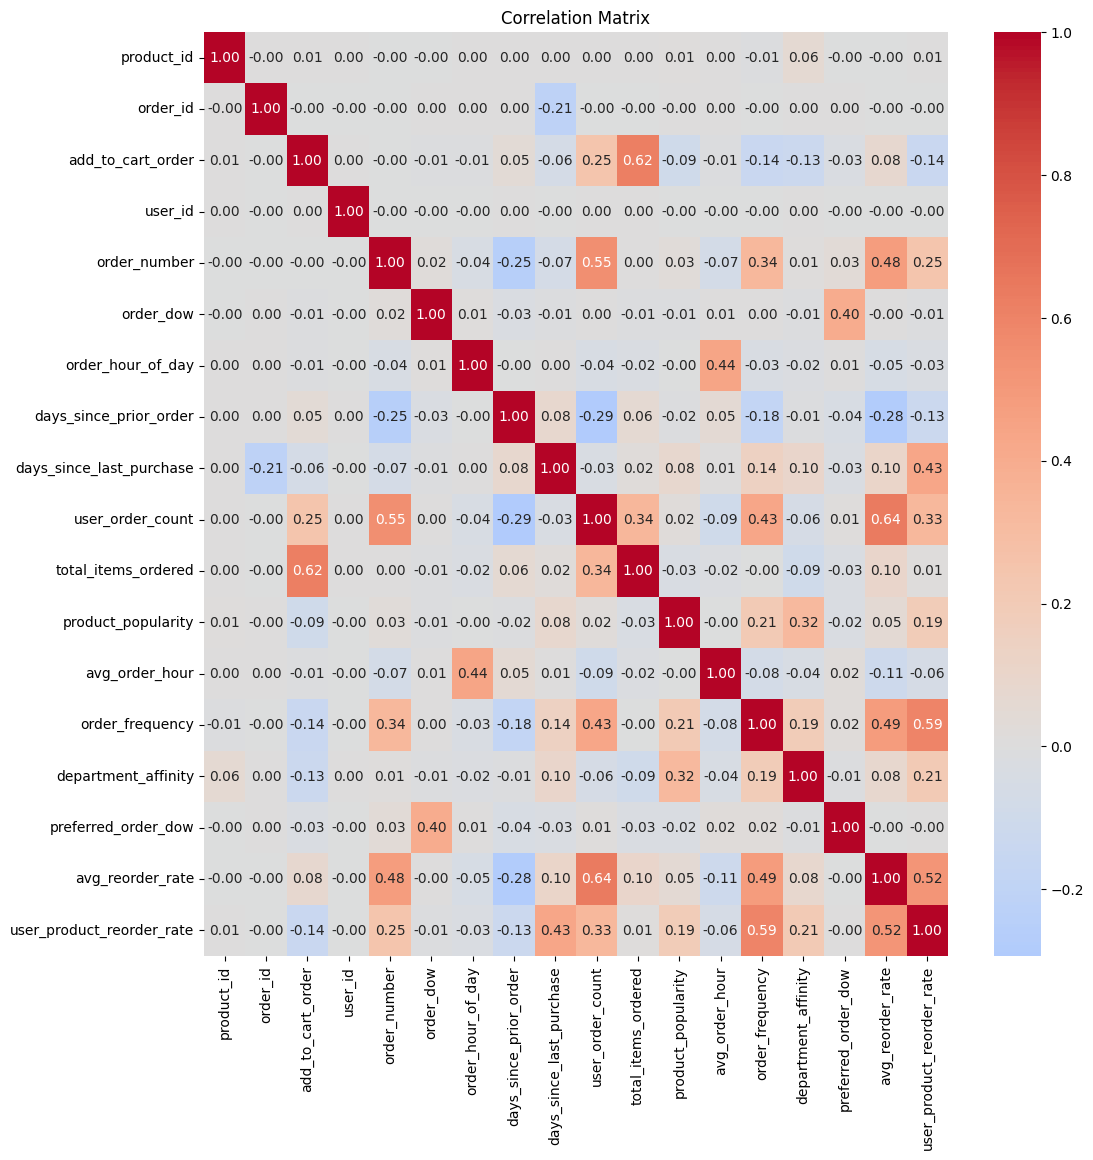

In [25]:

# Correlation Matrix - To identify highly correlated features
corr_matrix = X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Correlation Matrix')
plt.show()

In [9]:
# List of pairs of correlated columns to drop one from each
columns_to_drop = [
   ('order_hour_of_day', 'time_of_day'),   #Drop one from this pair
   ('product_popularity', 'product_reorder_frequency'),  # Drop one from this pair
   ('avg_order_hour', 'preferred_order_hour'),  # Drop one from this pair
    ('order_frequency', 'user_product_order_count')  # Drop one from this pair
]

# Drop one column from each pair
for col1, col2 in columns_to_drop:
    df = df.drop(columns=[col2])  # Drop the second column in each pair

# Verify the changes by printing the remaining columns
print(df.columns)

Index(['product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
       'preferred_order_dow', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')


In [14]:
# Assuming df is your DataFrame and 'reordered' is the target variable
X = df.drop(columns=['reordered'])  # Features
y = df['reordered']  # Target variable

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Fit Logistic Regression model
log_reg = LogisticRegression(max_iter=7, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=7, random_state=42)

In [22]:
from sklearn.model_selection import train_test_split
# Split X_test and y_test further into test and validation sets (50% each)
X_test_final, X_val, y_test_final, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Predict on the test set
y_pred = log_reg.predict(X_test_final)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test_final, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Alternatively, using the model's score method
accuracy_alternate = log_reg.score(X_test, y_test)
print(f"Model Accuracy (using score method): {accuracy_alternate:.4f}")

# Predict on the final test set
y_test_pred = log_reg.predict(X_test_final)

# Calculate the F1 score
f1 = f1_score(y_test_final, y_test_pred)
print(f"Model Accuracy (using f1-score method): {accuracy_alternate:.4f}")

Model Accuracy: 0.5896
Model Accuracy (using score method): 0.5896
Model Accuracy (using f1-score method): 0.5896


In [27]:


#Univariate Statistical Tests (ANOVA F-test)
# Select the top 10 features based on ANOVA F-statistic
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Top 10 features based on ANOVA F-test: {selected_features}")

Top 10 features based on ANOVA F-test: Index(['add_to_cart_order', 'order_number', 'days_since_last_purchase',
       'user_order_count', 'product_popularity', 'avg_order_hour',
       'order_frequency', 'department_affinity', 'avg_reorder_rate',
       'user_product_reorder_rate'],
      dtype='object')


In [26]:
#L1 Regularization (Lasso)** - Feature selection via Lasso
lasso = Lasso(alpha=0.01)  # Lasso regularization
lasso.fit(X, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features using Lasso regularization: {lasso_selected_features}")

Selected features using Lasso regularization: Index(['order_number', 'days_since_prior_order', 'user_product_reorder_rate'], dtype='object')
